same mindset but for reggression problems

In [1]:
from datetime import datetime
import time,pytz
import os, glob, subprocess, sys, uuid

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

import keras

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

GLOBAL_RANDOM_SEED = 42

random.seed(GLOBAL_RANDOM_SEED)
np.random.seed(GLOBAL_RANDOM_SEED)
tf.random.set_seed(GLOBAL_RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
initializer = keras.initializers.GlorotUniform(seed=GLOBAL_RANDOM_SEED)

2025-09-05 15:03:24.265171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757072004.344168  102803 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757072004.369347  102803 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-05 15:03:31.889051: E tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:55] The TF_FORCE_GPU_ALLOW_GROWTH environment variable is set but could not be parsed: "1". Valid values are "true" or "false". Using original config value of 1.
I0000 00:00:1757072011.890458  102803 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5223 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Lapto

In [2]:
import pandas as pd

# ========== LOAD & CLEAN ==========
file_path = "./data/concrete-dataset/Concrete_Data.xls"
df = pd.read_excel(file_path)

# rename columns (normalizing column names)
df.columns = [
    "Cement",
    "BlastFurnaceSlag",
    "FlyAsh",
    "Water",
    "Superplasticizer",
    "CoarseAggregate",
    "FineAggregate",
    "Age",
    "target"  # compressive strength
]

# inspect
print(df.head())
print(df.info())

   Cement  BlastFurnaceSlag  FlyAsh  Water  Superplasticizer  CoarseAggregate  \
0   540.0               0.0     0.0  162.0               2.5           1040.0   
1   540.0               0.0     0.0  162.0               2.5           1055.0   
2   332.5             142.5     0.0  228.0               0.0            932.0   
3   332.5             142.5     0.0  228.0               0.0            932.0   
4   198.6             132.4     0.0  192.0               0.0            978.4   

   FineAggregate  Age     target  
0          676.0   28  79.986111  
1          676.0   28  61.887366  
2          594.0  270  40.269535  
3          594.0  365  41.052780  
4          825.5  360  44.296075  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cement            1030 non-null   float64
 1   BlastFurnaceSlag  1030 non-null   float64
 2   FlyA

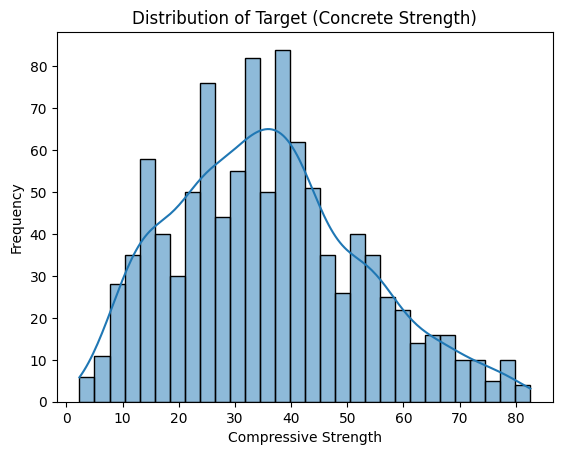

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['target'], bins=30, kde=True)
plt.title("Distribution of Target (Concrete Strength)")
plt.xlabel("Compressive Strength")
plt.ylabel("Frequency")
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# ========== SPLIT ==========
X = df.drop('target', axis=1)
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=GLOBAL_RANDOM_SEED
)

# ========== REGRESSORS & ENSEMBLES ==========
# Create base learners with better default parameters based on tuning results
base_learners = [
    ("lr", LinearRegression()),
    ("dt", DecisionTreeRegressor(max_depth=None, min_samples_split=9, min_samples_leaf=2, 
                                random_state=GLOBAL_RANDOM_SEED)),
    ("rf", RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=2,
                                min_samples_leaf=1, max_features='log2',
                                random_state=GLOBAL_RANDOM_SEED, n_jobs=1)),
    ("svr", SVR(C=7.9, epsilon=0.31, kernel='rbf')),
    ("knn", KNeighborsRegressor(n_neighbors=7, p=1, weights='distance')),
    ("xgb", XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1,
                        subsample=0.8, colsample_bytree=0.9,
                        objective="reg:squarederror", 
                        random_state=GLOBAL_RANDOM_SEED, n_jobs=1))
]

# VotingRegressor with optimized base models
voting_reg = VotingRegressor(estimators=base_learners, n_jobs=-1)

# StackingRegressor with optimized base models
stacking_reg = StackingRegressor(
    estimators=base_learners,
    final_estimator=LinearRegression(),
    passthrough=True,
    cv=5,
    n_jobs=-1
)

selectors = {
    "None": [],  # baseline, no feature selection
    "FReg": [("select", SelectKBest(f_regression, k=5))],
    "MutInfo": [("select", SelectKBest(mutual_info_regression, k=5))],
    "PCA": [("reduce", PCA(n_components=5))]
}

models = {
    "LinReg": LinearRegression(),
    "DecTree": DecisionTreeRegressor(random_state=GLOBAL_RANDOM_SEED),
    "RandForest": RandomForestRegressor(n_estimators=200, random_state=GLOBAL_RANDOM_SEED, n_jobs=1),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=GLOBAL_RANDOM_SEED, n_jobs=1),
    "Voting": voting_reg,
    "Stacking": stacking_reg
}

# ========== DEFINE FEATURE SELECTION EXTRACTION FUNCTION ==========
def get_selected_features(pipe, X_train):
    """
    Extract selected feature names from a pipeline with feature selection steps
    """
    try:
        # Check for feature selection steps
        if "select" in pipe.named_steps:
            sel = pipe.named_steps["select"]
            if hasattr(sel, "get_support"):
                mask = sel.get_support()
                return X_train.columns[mask].tolist()
            if hasattr(sel, "top_features_"):
                idxs = list(sel.top_features_)
                return [X_train.columns[i] for i in idxs]
        
        # Check for dimensionality reduction steps
        if "reduce" in pipe.named_steps:
            pc = pipe.named_steps["reduce"]
            if hasattr(pc, "n_components_"):
                return [f"PC{i+1}" for i in range(pc.n_components_)]
            elif hasattr(pc, "n_components"):
                return [f"PC{i+1}" for i in range(pc.n_components)]
    
    except Exception as e:
        return [f"[Error extracting features: {e}]"]
    
    return ["[No selector to extract from]"]

# ========== DEFINE HYPERPARAMETER GRIDS ==========
param_grids = {
    "LinReg": {
        "model__fit_intercept": [True, False],
        "model__positive": [True, False]
    },
    "DecTree": {
        "model__max_depth": [None, 5, 10, 15, 20, 25],
        "model__min_samples_split": randint(2, 20),
        "model__min_samples_leaf": randint(1, 10),
        "model__max_features": ['sqrt', 'log2', None]
    },
    "RandForest": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ['sqrt', 'log2']
    },
    "SVR": {
        "model__C": uniform(0.1, 10),
        "model__epsilon": uniform(0.01, 0.5),
        "model__kernel": ['linear', 'rbf', 'poly']
    },
    "KNN": {
        "model__n_neighbors": randint(3, 15),
        "model__weights": ['uniform', 'distance'],
        "model__p": [1, 2]  # 1: manhattan, 2: euclidean
    },
    "XGBoost": {
        "model__n_estimators": [250, 300, 350],
        "model__max_depth": [5, 6, 7],
        "model__learning_rate": [0.08, 0.1, 0.12],
        "model__subsample": [0.75, 0.8, 0.85],
        "model__colsample_bytree": [0.85, 0.9, 0.95]
    }
}

# ========== ADD ENSEMBLE TUNING ==========
param_grids["Voting"] = {
    "model__weights": [
        [1, 1, 1, 1, 1, 1],  # equal weights
        [1, 1, 2, 1, 1, 2],  # favor RF and XGBoost
        [1, 1, 3, 1, 1, 3]   # strong favor to best performers
    ]
}

# ========== MODIFIED PIPELINE WITH TUNING ==========
results = []

# Calculate number of parameter combinations
def get_param_space_size(param_grid):
    size = 1
    for key, values in param_grid.items():
        size *= len(values) if hasattr(values, '__len__') else values.rvs(1000).size
    return size

for sel_name, sel_steps in selectors.items():
    for model_name, model in models.items():
        print(f"Processing: {sel_name} + {model_name}")
        
        # For ensemble methods, use tuning if available
        if model_name in ["Voting", "Stacking"] and model_name in param_grids:
            steps = [("scaler", StandardScaler())] + sel_steps + [("model", model)]
            pipe = ImbPipeline(steps)
            
            print(f"  Tuning {model_name}...")
            search = RandomizedSearchCV(
                pipe,
                param_grids[model_name],
                n_iter=5,  # Fewer iterations for ensembles
                cv=3,
                scoring='neg_mean_squared_error',
                random_state=GLOBAL_RANDOM_SEED,
                n_jobs=-1,
                verbose=0
            )
            
            search.fit(X_train, y_train)
            best_estimator = search.best_estimator_
            y_pred = best_estimator.predict(X_test)
            
            tuning_info = {
                "best_params": search.best_params_,
                "best_score": -search.best_score_
            }
            
            tuned = True
            current_pipe = best_estimator
            
        elif model_name in ["Voting", "Stacking"]:
            # No tuning grid for this ensemble, use default
            steps = [("scaler", StandardScaler())] + sel_steps + [("model", model)]
            pipe = ImbPipeline(steps)
            pipe.fit(X_train, y_train)
            
            y_pred = pipe.predict(X_test)
            tuning_info = {}
            tuned = False
            current_pipe = pipe
            
        else:
            # For non-ensemble models that can be tuned
            steps = [("scaler", StandardScaler())] + sel_steps + [("model", model)]
            pipe = ImbPipeline(steps)
            
            # Check if we have a parameter grid for this model
            if model_name in param_grids:
                print(f"  Tuning {model_name}...")
                param_space_size = get_param_space_size(param_grids[model_name])
                n_iter = min(15, param_space_size)  # Don't exceed total parameter space
                
                search = RandomizedSearchCV(
                    pipe,
                    param_grids[model_name],
                    n_iter=n_iter,
                    cv=3,
                    scoring='neg_mean_squared_error',
                    random_state=GLOBAL_RANDOM_SEED,
                    n_jobs=-1,
                    verbose=0
                )
                
                search.fit(X_train, y_train)
                best_estimator = search.best_estimator_
                y_pred = best_estimator.predict(X_test)
                
                tuning_info = {
                    "best_params": search.best_params_,
                    "best_score": -search.best_score_
                }
                
                tuned = True
                current_pipe = best_estimator
            else:
                # No tuning grid, use default
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_test)
                tuning_info = {}
                tuned = False
                current_pipe = pipe
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        ev = explained_variance_score(y_test, y_pred)
        
        # Get selected features
        if sel_name == "None":
            selected_features = X_train.columns.tolist()
        else:
            selected_features = get_selected_features(current_pipe, X_train)
        
        # Store results
        results.append({
            "Selector": sel_name,
            "Model": model_name,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "ExplainedVar": ev,
            "Selected Features": selected_features,
            "Tuned": tuned,
            "Tuning Info": tuning_info if tuned else "No tuning performed"
        })

# ========== DISPLAY AND SAVE RESULTS ==========
df_results = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)

# Display top 20 results by RMSE
print("\nTop 20 Models by RMSE:")
print(df_results.sort_values(by="RMSE").head(20).to_string(index=False))

# Save detailed results to CSV
df_results.to_csv("regression_tuning_results.csv", index=False)
print("\nDetailed results saved to 'regression_tuning_results.csv'")

# Display best model for each feature selection method
print("\nBest model for each feature selection method:")
for selector in selectors.keys():
    selector_results = df_results[df_results["Selector"] == selector]
    best_result = selector_results.loc[selector_results["RMSE"].idxmin()]
    print(f"{selector}: {best_result['Model']} (RMSE: {best_result['RMSE']:.4f})")

# Display best overall model
best_overall = df_results.loc[df_results["RMSE"].idxmin()]
print(f"\nBest Overall Model: {best_overall['Model']} with {best_overall['Selector']} "
      f"(RMSE: {best_overall['RMSE']:.4f}, R²: {best_overall['R2']:.4f})")

# # ========== PIPELINE & EVALUATION (regression) ==========
# from imblearn.pipeline import Pipeline as ImbPipeline  # OK to reuse pipeline class
# results = []

# for sel_name, sel_steps in selectors.items():
#     for model_name, model in models.items():
#         steps = [("scaler", StandardScaler())] + sel_steps + [("model", model)]
#         pipe = ImbPipeline(steps)
#         pipe.fit(X_train, y_train)

#         # regression predictions
#         y_pred = pipe.predict(X_test)

#         # metrics
#         mse = mean_squared_error(y_test, y_pred)
#         rmse = np.sqrt(mse)
#         mae = mean_absolute_error(y_test, y_pred)
#         r2 = r2_score(y_test, y_pred)
#         ev = explained_variance_score(y_test, y_pred)

#         # Extract selected feature names in a robust way
#         def get_selected_features(pipe, X_train):
#             try:
#                 if "select" in pipe.named_steps:
#                     sel = pipe.named_steps["select"]
#                     if hasattr(sel, "get_support"):
#                         mask = sel.get_support()
#                         return X_train.columns[mask].tolist()
#                     if hasattr(sel, "top_features_"):
#                         idxs = list(sel.top_features_)
#                         return [X_train.columns[i] for i in idxs]
#                 if "reduce" in pipe.named_steps:
#                     pc = pipe.named_steps["reduce"]
#                     if hasattr(pc, "n_components_"):
#                         return [f"PC{i+1}" for i in range(pc.n_components_)]
#             except Exception as e:
#                 return [f"[Error extracting features: {e}]"]
#             return ["[No selector to extract from]"]

#         if sel_name == "None":
#             selected_features = X_train.columns.tolist()
#         else:
#             selected_features = get_selected_features(pipe, X_train)
#         # selected_features = get_selected_features(pipe, X_train)

#         results.append({
#             "Selector": sel_name,
#             "Model": model_name,
#             "MSE": mse,
#             "RMSE": rmse,
#             "MAE": mae,
#             "R2": r2,
#             "ExplainedVar": ev,
#             "Selected Features": selected_features
#         })

# # summary
# df_results = pd.DataFrame(results)
# pd.set_option("display.max_colwidth", None)
# print(df_results.sort_values(by="RMSE").to_string(index=False))

Processing: None + LinReg
  Tuning LinReg...
Processing: None + DecTree
  Tuning DecTree...
Processing: None + RandForest
  Tuning RandForest...
Processing: None + SVR
  Tuning SVR...
Processing: None + KNN
  Tuning KNN...
Processing: None + XGBoost
  Tuning XGBoost...
Processing: None + Voting
  Tuning Voting...


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Processing: None + Stacking
Processing: FReg + LinReg
  Tuning LinReg...
Processing: FReg + DecTree
  Tuning DecTree...
Processing: FReg + RandForest
  Tuning RandForest...
Processing: FReg + SVR
  Tuning SVR...
Processing: FReg + KNN
  Tuning KNN...
Processing: FReg + XGBoost
  Tuning XGBoost...
Processing: FReg + Voting
  Tuning Voting...


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Processing: FReg + Stacking
Processing: MutInfo + LinReg
  Tuning LinReg...
Processing: MutInfo + DecTree
  Tuning DecTree...
Processing: MutInfo + RandForest
  Tuning RandForest...
Processing: MutInfo + SVR
  Tuning SVR...
Processing: MutInfo + KNN
  Tuning KNN...
Processing: MutInfo + XGBoost
  Tuning XGBoost...
Processing: MutInfo + Voting
  Tuning Voting...


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Processing: MutInfo + Stacking
Processing: PCA + LinReg
  Tuning LinReg...
Processing: PCA + DecTree
  Tuning DecTree...
Processing: PCA + RandForest
  Tuning RandForest...
Processing: PCA + SVR
  Tuning SVR...
Processing: PCA + KNN
  Tuning KNN...
Processing: PCA + XGBoost
  Tuning XGBoost...
Processing: PCA + Voting
  Tuning Voting...


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Processing: PCA + Stacking

Top 20 Models by RMSE:
Selector      Model       MSE     RMSE      MAE       R2  ExplainedVar                                                                                Selected Features  Tuned                                                                                                                                                                                         Tuning Info
    None   Stacking 17.736492 4.211472 2.855454 0.931169      0.931720 [Cement, BlastFurnaceSlag, FlyAsh, Water, Superplasticizer, CoarseAggregate, FineAggregate, Age]  False                                                                                                                                                                                 No tuning performed
    None    XGBoost 18.034297 4.246681 2.926433 0.930013      0.931019 [Cement, BlastFurnaceSlag, FlyAsh, Water, Superplasticizer, CoarseAggregate, FineAggregate, Age]   True       {'best_params': {'model__s

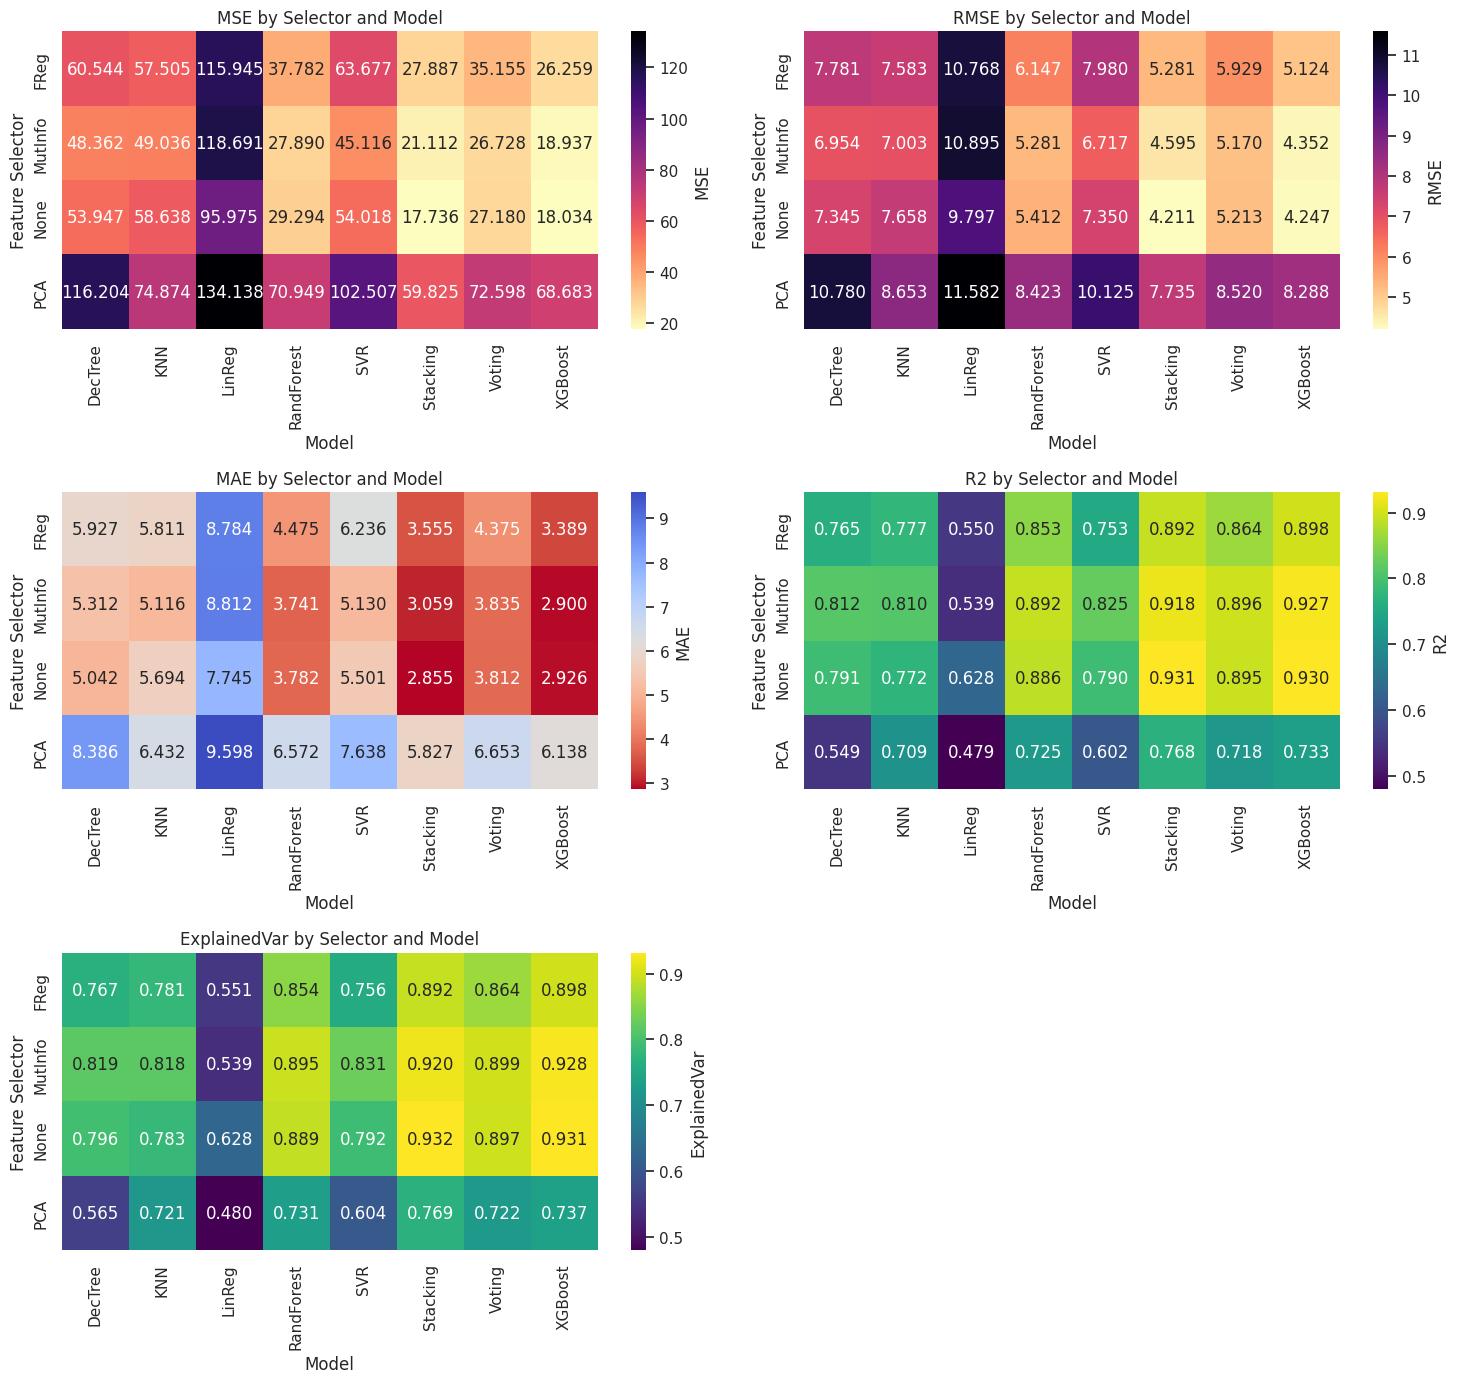

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["MSE", "RMSE", "MAE", "R2", "ExplainedVar"]
cmap_dict = {
    "MSE": "magma_r",          # reversed so lower MSE is darker
    "RMSE": "magma_r",
    "MAE": "coolwarm_r",
    "R2": "viridis",            # higher is better
    "ExplainedVar": "viridis"
}

plt.figure(figsize=(15, 14))
sns.set_theme(style="whitegrid")

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    metric_matrix = df_results.pivot(index="Selector", columns="Model", values=metric)
    sns.heatmap(metric_matrix, annot=True, fmt=".3f", cmap=cmap_dict[metric], cbar_kws={'label': metric})
    plt.title(f"{metric} by Selector and Model")
    plt.xlabel("Model")
    plt.ylabel("Feature Selector")

plt.tight_layout()
plt.show()

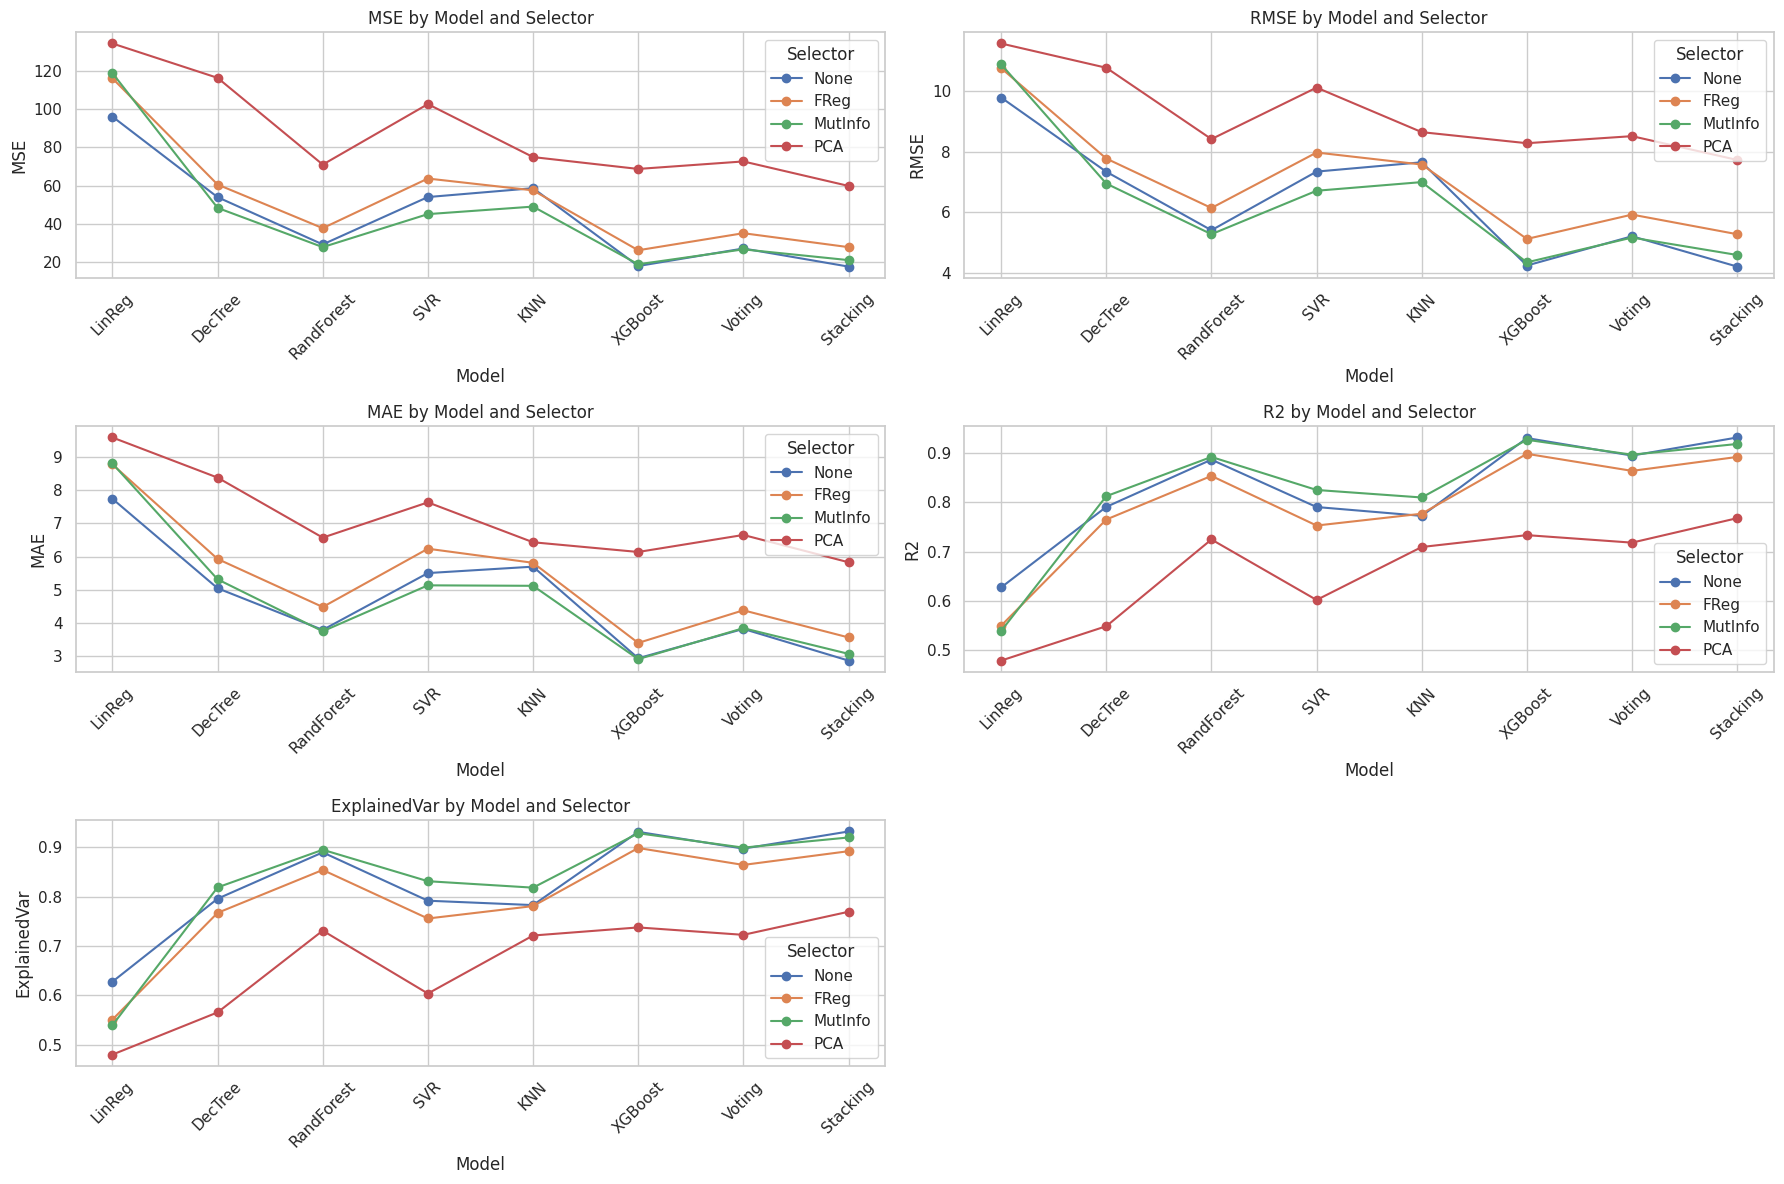

In [6]:
import matplotlib.pyplot as plt

# Metrics to visualize
metrics = ["MSE", "RMSE", "MAE", "R2", "ExplainedVar"]

# Unique models and selectors
models = df_results['Model'].unique()
selectors = df_results['Selector'].unique()

plt.figure(figsize=(18, 12))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    
    for sel in selectors:
        subset = df_results[df_results['Selector'] == sel]
        subset = subset.set_index('Model').reindex(models)
        plt.plot(models, subset[metric], marker='o', label=sel)
    
    plt.title(f"{metric} by Model and Selector")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Selector")

plt.tight_layout()
plt.show()